## Using Clustering for Image Segmentation

_Image segmentation_ is the task of partitioning an image into multiple
segments. In _semantic segmentation_, all pixels that are part of the same
object type get assigned to the same segment. For example, in a self-driving
car’s vision system, all pixels that are part of a pedestrian’s image might be assigned to the “pedestrian” segment (there would be one segment
containing all the pedestrians). In _instance segmentation_, all pixels that are part of the same individual object are assigned to the same segment. In this case there would be a different segment for each pedestrian. The state of the art in semantic or instance segmentation today is achieved using complex architectures based on convolutional neural networks.

Here, we are going to do something much simpler: _color segmentation_. We
will simply assign pixels to the same segment if they have a similar color.
In some applications, this may be sufficient. For example, if you want to
analyze satellite images to measure how much total forest area there is in a
region, color segmentation may be just fine.

In [1]:
from PIL import Image
import numpy as np
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

filepath = 'images/ladybug.png'
image = np.asarray(Image.open(filepath))
image.shape

(533, 800, 3)

The image is represented as a 3D array. The first dimension’s size is the
height; the second is the width; and the third is the number of color
channels, in this case red, green, and blue (RGB). In other words, for each
pixel there is a 3D vector containing the intensities of red, green, and blue,
as unsigned 8-bit integers between 0 and 255. Some images may have fewer
channels, such as grayscale images (one channel). And some images may
have more channels, such as images with an additional _alpha channel_ for
transparency, or satellite images which often contain channels for many
light frequencies (e.g., infrared).

The following code reshapes the array to get a long list of RGB colors, then
it clusters these colors using K-Means with 8 clusters, and it creates a
`segmented_img` array containing the nearest cluster center for each pixel
(i.e., the mean color of each pixel’s cluster), and lastly it reshapes this array
to the original image shape. The third line uses advanced NumPy indexing:
for example, if the first 10 labels in `kmeans_.labels_` are equal to 1,
then the first 10 colors in segmented_img are equal to
`kmeans.cluster_centers_[1]`.

In [2]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

You can
experiment with various numbers of clusters, as shown in the figure. When
you use fewer than eight clusters, notice that the ladybug’s flashy red color
fails to get a cluster of its own: it gets merged with colors from the environment. This is because K-Means prefers clusters of similar sizes. The
ladybug is small—much smaller than the rest of the image—so even though
its color is flashy, K-Means fails to dedicate a cluster to it.

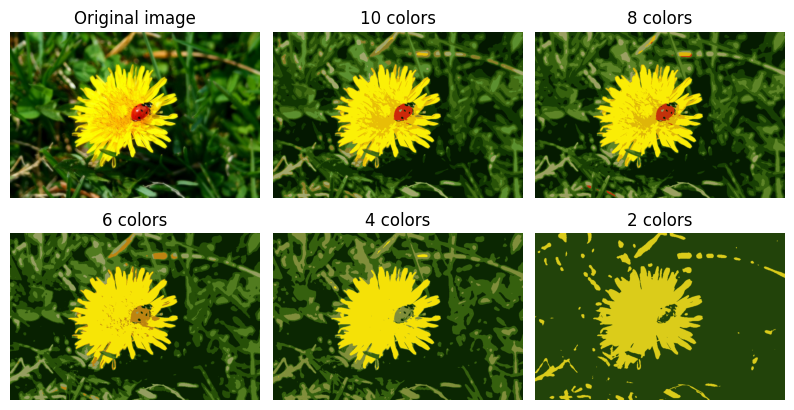

In [ ]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

plt.figure(figsize=(10, 5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(2, 3, 1)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(2, 3, 2 + idx)
    plt.imshow(segmented_imgs[idx] / 255)
    plt.title(f"{n_clusters} colors")
    plt.axis('off')

plt.show()

## Using Clustering for Semi-Supervised Learning

Another use case for clustering is in semi-supervised learning, when we
have plenty of unlabeled instances and very few labeled instances. In this
section, we’ll use the digits dataset, which is a simple MNIST-like dataset
containing 1,797 grayscale 8 × 8 images representing the digits 0 to 9. First,
let’s load and split the dataset (it’s already shuffled):

In [1]:
from sklearn.datasets import load_digits
X_digits, y_digits = load_digits(return_X_y=True)
X_train, y_train = X_digits[:1400], y_digits[:1400]
X_test, y_test = X_digits[1400:], y_digits[1400:]

We will pretend we only have labels for 50 instances. To get a baseline
performance, let’s train a Logistic Regression model on these 50 labeled
instances:

In [2]:
from sklearn.linear_model import LogisticRegression
n_labeled = 50
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

LogisticRegression(max_iter=10000)

Let’s measure the accuracy of this model on the test set (note that the test
set must be labeled):

In [3]:
log_reg.score(X_test, y_test)

0.7581863979848866

In [4]:
# Measure the accuracy when we use the whole training set
log_reg_full = LogisticRegression(max_iter=10_000)
log_reg_full.fit(X_train, y_train)
log_reg_full.score(X_test, y_test)

0.9093198992443325

The model’s accuracy is just 75%, while it would have reached 90% if
we had trained it on the full training set. Let’s see how we can do better.
First, let’s cluster the training set into 50 clusters. Then for each cluster, et’s find the image closest to the centroid. Let’s call these images the _representative images_:

In [5]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

k = 50
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = X_digits_dist.argmin(axis=0)
X_representative_digits = X_train[representative_digit_idx]

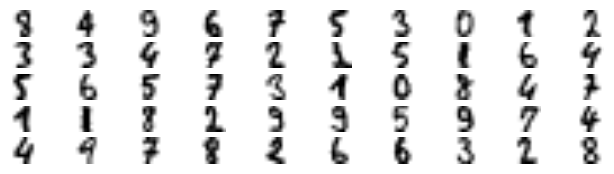

In [6]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary",
               interpolation="bilinear")
    plt.axis('off')

plt.show()

Let’s look at each image and manually label it:

In [7]:
import numpy as np
y_representative_digits = np.array([
    8, 4, 9, 6, 7, 5, 3, 0, 1, 2,
    3, 3, 4, 7, 2, 1, 5, 1, 6, 4,
    5, 6, 5, 7, 3, 1, 0, 8, 4, 7,
    1, 1, 8, 2, 9, 9, 5, 9, 7, 4,
    4, 9, 7, 8, 2, 6, 6, 3, 2, 8
])

In [8]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.8387909319899244

We jumped from 75% accuracy to 83%, although we are still
only training the model on 50 instances. Since it is often costly and painful
to label instances, especially when it has to be done manually by experts, it
is a good idea to label representative instances rather than just random
instances.
But perhaps we can go one step further: what if we propagated the labels to
all the other instances in the same cluster? This is called _label propagation_:

In [9]:
y_train_propagated = np.empty(len(X_train), dtype=np.int64)
for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]

Now let’s train the model again and look at its performance:

In [10]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train, y_train_propagated)
log_reg.score(X_test, y_test)

0.8589420654911839

We got another significant accuracy boost! Let’s see if we can do even
better by ignoring the 1% instances that are farthest from their cluster
center: this should eliminate some outliers. The following code first
computes the distance from each instance to its closest cluster center, then
for each cluster it sets the 1% largest distances to –1. Lastly, it creates a set
without these instances marked with a –1 distance.

In [35]:
percentile_closest = 80

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [36]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)

0.8463476070528967

In [37]:
def show_images(data, n=None, max_cols=10):
    if not n:
        n = data.shape[0]
    for i in range(n):
        plt.subplot(n//max_cols+1, max_cols, i+1)
        plt.imshow(data[i].reshape(8, 8), cmap='binary')
        plt.axis('off')
    plt.show()

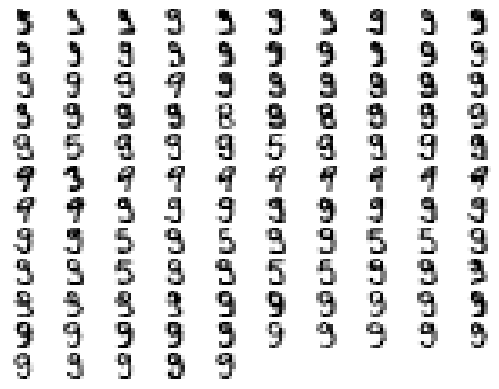

In [40]:
j = 9
show_images(X_train_partially_propagated[y_train_partially_propagated==j])

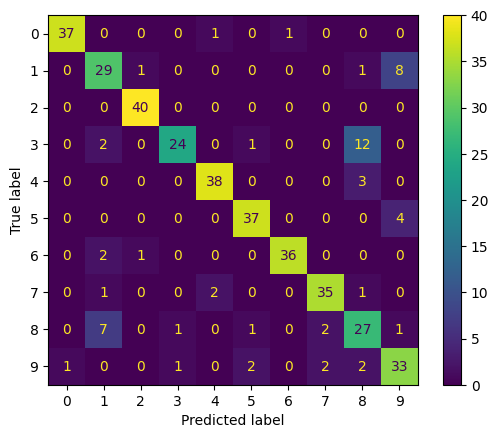

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = log_reg.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

## Cluster the Olivetti Faces Dataset

The classic Olivetti faces dataset contains 400 grayscale 64 × 64–pixel images of faces. Each image is flattened to a 1D vector of size 4,096. 40 different people were photographed (10 times each), and the usual task is to train a model that can predict which person is represented in each picture. Load the dataset using the `sklearn.datasets.fetch_olivetti_faces()` function.

In [1]:
from sklearn.datasets import fetch_olivetti_faces

olivetti = fetch_olivetti_faces()

In [2]:
dir(olivetti)

['DESCR', 'data', 'images', 'target']

In [3]:
print(olivetti.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position
    (with tolerance for some side movement).

**Data Set Characteristics:**

=================   =====================
Classes              

In [4]:
olivetti.target

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
       22, 22, 22, 22, 22

In [5]:
from matplotlib import pyplot as plt

def show_olivetti_images(data, n=None, max_cols=5):
    if not n:
        n = data.shape[0]
    plt.figure(figsize=(8, 4))
    for i in range(n):
        plt.subplot(n//max_cols+1, max_cols, i+1)
        plt.imshow(data[i].reshape(64, 64))
        plt.axis('off')
    plt.show()

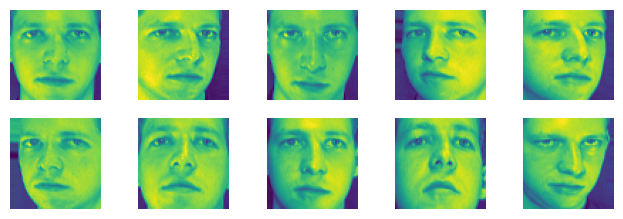

In [6]:
show_olivetti_images(olivetti.data[olivetti.target == 0])

Then split it into a training set, a validation set, and a test set (note that the dataset is already scaled between 0 and 1). Since the dataset is quite small, you probably want to use stratified sampling to ensure that there are the same number of images per person in each set.

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=40, random_state=42)
train_valid_idx, test_idx = next(strat_split.split(olivetti.data, olivetti.target))
X_train_valid = olivetti.data[train_valid_idx]
y_train_valid = olivetti.target[train_valid_idx]
X_test = olivetti.data[test_idx]
y_test = olivetti.target[test_idx]

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=80, random_state=43)
train_idx, valid_idx = next(strat_split.split(X_train_valid, y_train_valid))
X_train = X_train_valid[train_idx]
y_train = y_train_valid[train_idx]
X_valid = X_train_valid[valid_idx]
y_valid = y_train_valid[valid_idx]

In [8]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(280, 4096) (280,)
(80, 4096) (80,)
(40, 4096) (40,)


To speed things up, we'll reduce the data's dimensionality using PCA:

In [9]:
from sklearn.decomposition import PCA

pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

pca.n_components_

np.int64(199)

In [10]:
print(X_train_pca.shape)

(280, 199)


Next, cluster the images using K-Means, and ensure that you have a good number of clusters.

In [11]:
from sklearn.cluster import KMeans

k_range = range(5, 150, 5)
kmeans_per_k = []
for k in k_range:
    print(f'{k=}')
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X_train_pca)
    kmeans_per_k.append(kmeans)

k=5
k=10
k=15
k=20
k=25
k=30
k=35
k=40
k=45
k=50
k=55
k=60
k=65
k=70
k=75
k=80
k=85
k=90
k=95
k=100
k=105
k=110
k=115
k=120
k=125
k=130
k=135
k=140
k=145


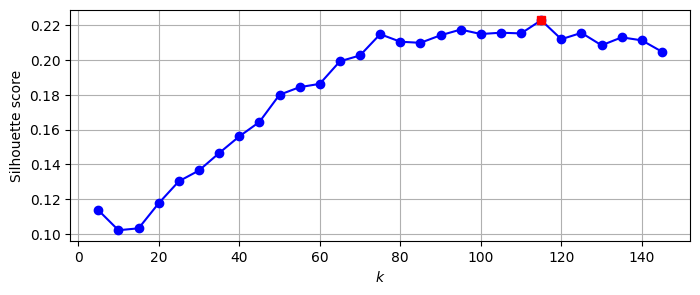

In [12]:
import numpy as np
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(X_train_pca, model.labels_)
                    for model in kmeans_per_k]
best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, silhouette_scores, 'bo-')
plt.xlabel('$k$')
plt.ylabel("Silhouette score")
plt.plot(best_k, best_score, "rs")
plt.grid()
plt.show()

In [13]:
best_k

115

In [14]:
best_model = kmeans_per_k[best_index]

Cluster 0


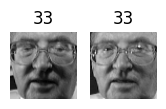

Cluster 1


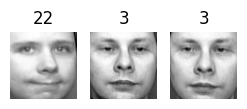

Cluster 2


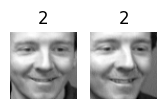

Cluster 3


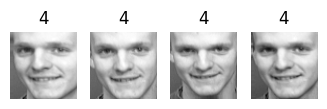

Cluster 4


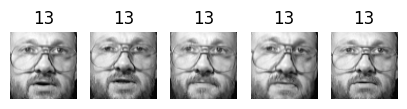

Cluster 5


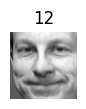

Cluster 6


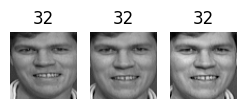

Cluster 7


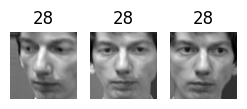

Cluster 8


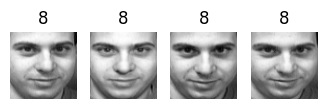

Cluster 9


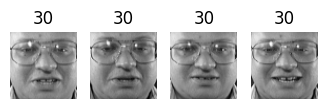

Cluster 10


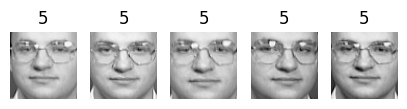

Cluster 11


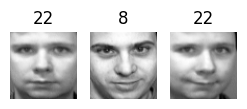

Cluster 12


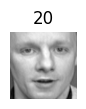

Cluster 13


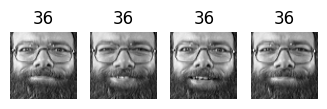

Cluster 14


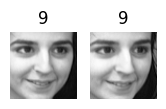

Cluster 15


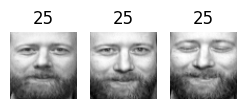

Cluster 16


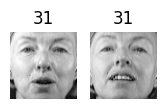

Cluster 17


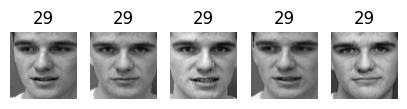

Cluster 18


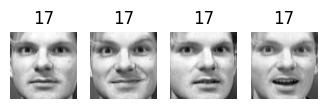

Cluster 19


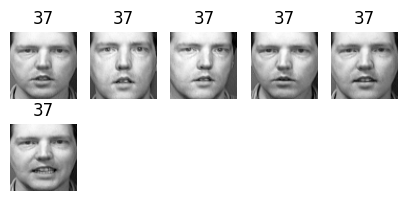

Cluster 20


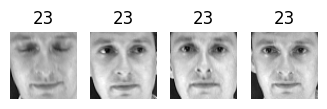

Cluster 21


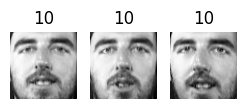

Cluster 22


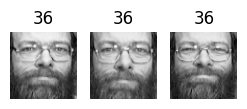

Cluster 23


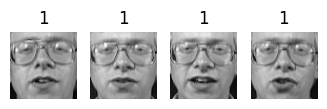

Cluster 24


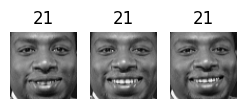

Cluster 25


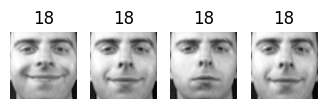

Cluster 26


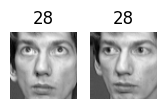

Cluster 27


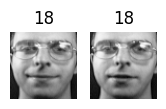

Cluster 28


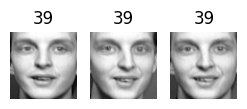

Cluster 29


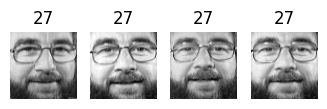

Cluster 30


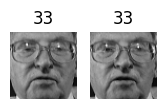

Cluster 31


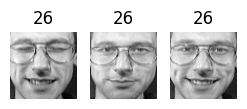

Cluster 32


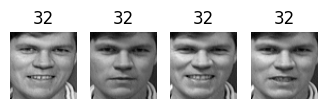

Cluster 33


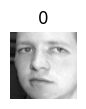

Cluster 34


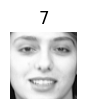

Cluster 35


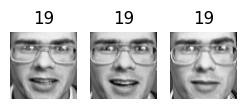

Cluster 36


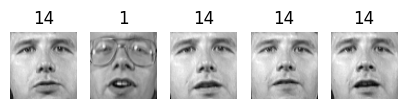

Cluster 37


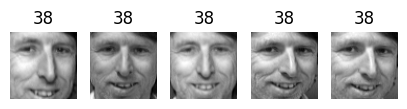

Cluster 38


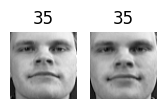

Cluster 39


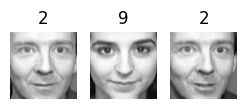

Cluster 40


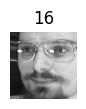

Cluster 41


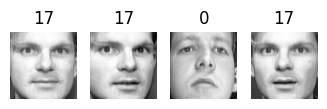

Cluster 42


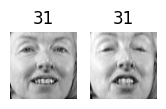

Cluster 43


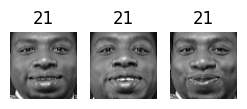

Cluster 44


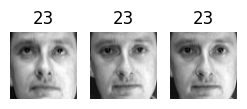

Cluster 45


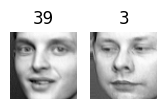

Cluster 46


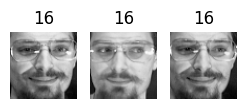

Cluster 47


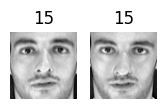

Cluster 48


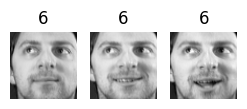

Cluster 49


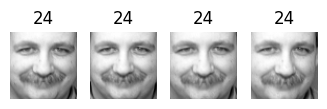

Cluster 50


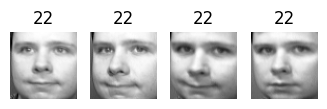

Cluster 51


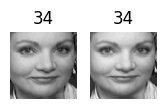

Cluster 52


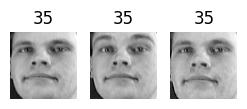

Cluster 53


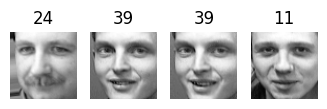

Cluster 54


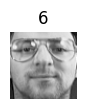

Cluster 55


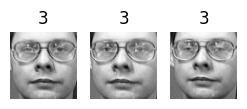

Cluster 56


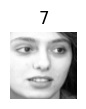

Cluster 57


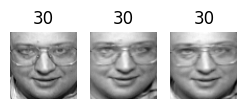

Cluster 58


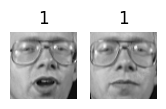

Cluster 59


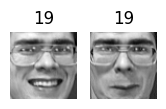

Cluster 60


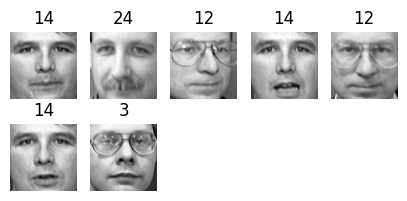

Cluster 61


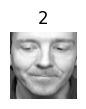

Cluster 62


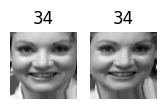

Cluster 63


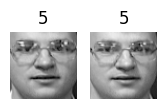

Cluster 64


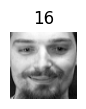

Cluster 65


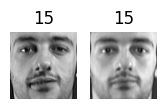

Cluster 66


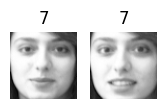

Cluster 67


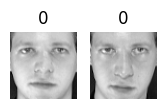

Cluster 68


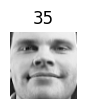

Cluster 69


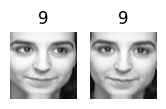

Cluster 70


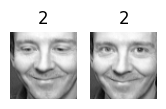

Cluster 71


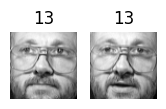

Cluster 72


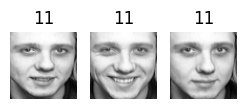

Cluster 73


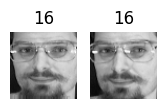

Cluster 74


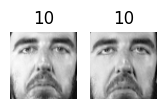

Cluster 75


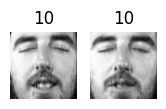

Cluster 76


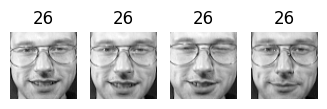

Cluster 77


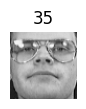

Cluster 78


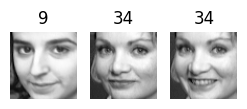

Cluster 79


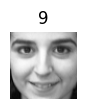

Cluster 80


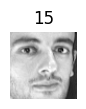

Cluster 81


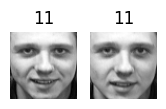

Cluster 82


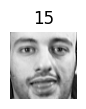

Cluster 83


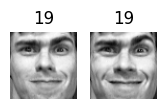

Cluster 84


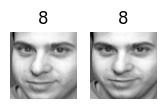

Cluster 85


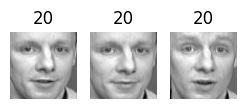

Cluster 86


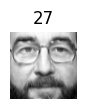

Cluster 87


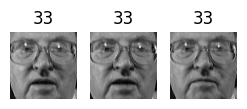

Cluster 88


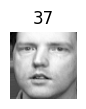

Cluster 89


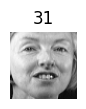

Cluster 90


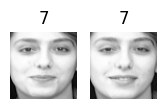

Cluster 91


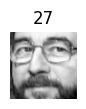

Cluster 92


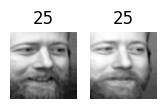

Cluster 93


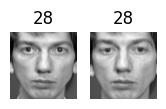

Cluster 94


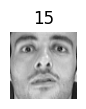

Cluster 95


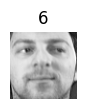

Cluster 96


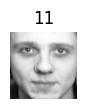

Cluster 97


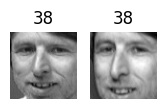

Cluster 98


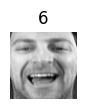

Cluster 99


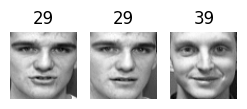

Cluster 100


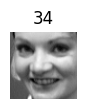

Cluster 101


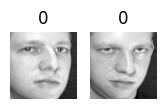

Cluster 102


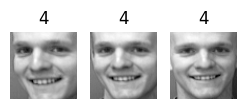

Cluster 103


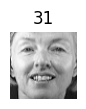

Cluster 104


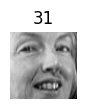

Cluster 105


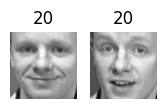

Cluster 106


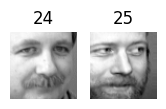

Cluster 107


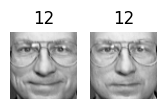

Cluster 108


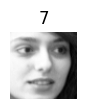

Cluster 109


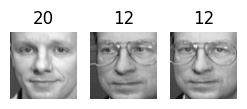

Cluster 110


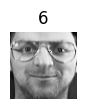

Cluster 111


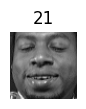

Cluster 112


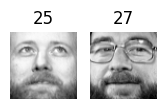

Cluster 113


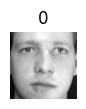

Cluster 114


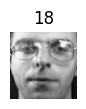

In [15]:
def plot_faces(faces, labels, n_cols=5):
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

for cluster_id in np.unique(best_model.labels_):
    print("Cluster", cluster_id)
    in_cluster = best_model.labels_==cluster_id
    faces = X_train[in_cluster]
    labels = y_train[in_cluster]
    plot_faces(faces, labels)